<a href="https://colab.research.google.com/github/Nsimaar99/Kaggle-Project/blob/master/Deepie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!git clone https://github.com/udacity/deep-learning-v2-pytorch.git

fatal: destination path 'deep-learning-v2-pytorch' already exists and is not an empty directory.


In [49]:
import numpy as np
import torch

In [50]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Number of subprocesses to use for dataloading
num_workers = 0
# Batch size for training, validation, and testing
batch_size = 20
# Percentage of training set to be used for validation
valid_size = 0.2

# Convert data to torch.FloatTensor
transforms = transforms.ToTensor()

# Loading the training data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms)

# Loading the test data
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms)

# Obtain the training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(indices[split:])
valid_sampler = SubsetRandomSampler(indices[:split])

# Prepare the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


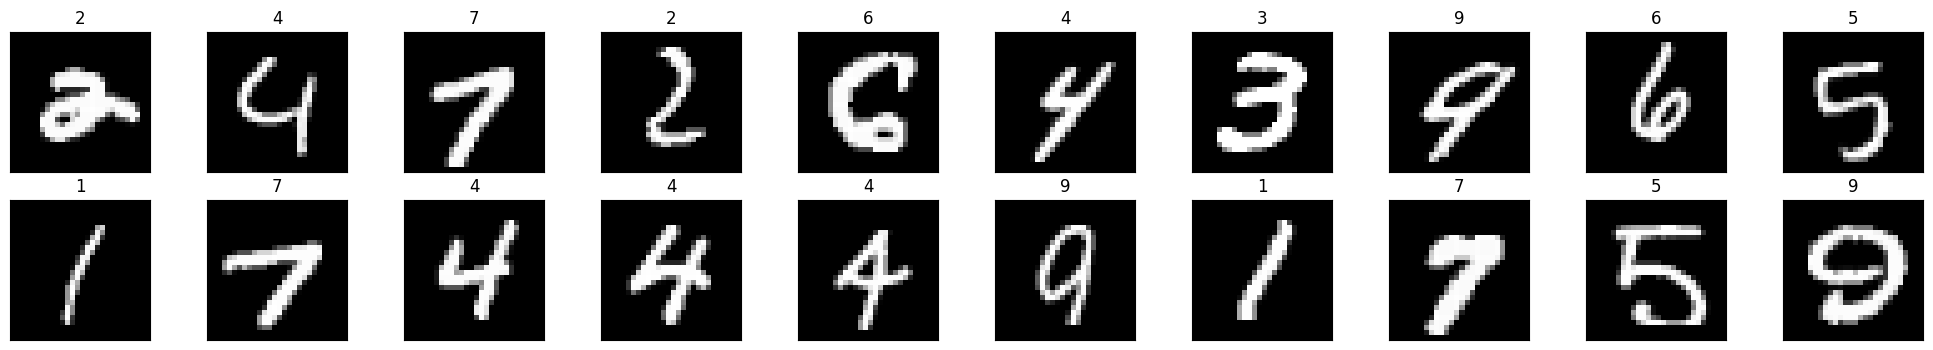

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use next(dataiter) instead of dataiter.next()
images = images.numpy()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    # Ensure the number of columns is an integer by using '//' for integer division
    ax = fig.add_subplot(2, 20 // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # Print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

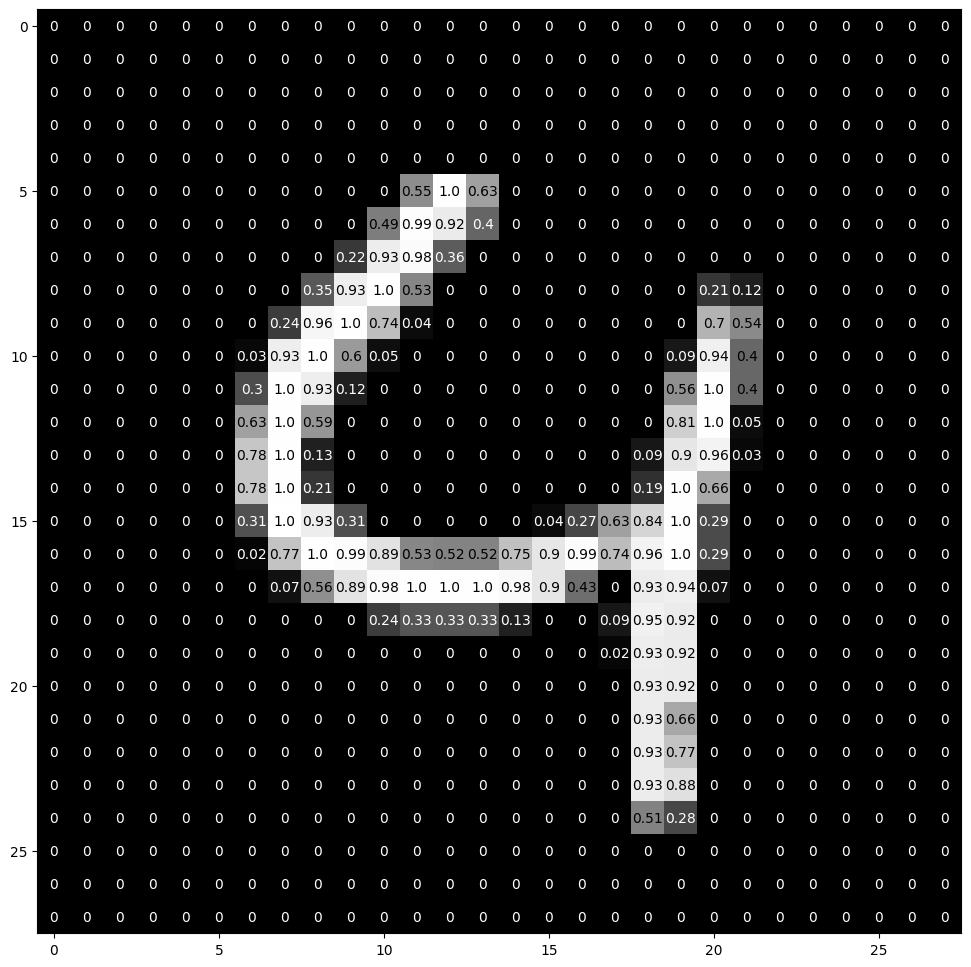

In [52]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [53]:
import torch.nn as nn
import torch.nn.functional as F

# Define the NN architecture
class Net(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Net, self).__init__()
        # Linear layer (28 * 28 -> 512)
        self.fc1 = nn.Linear(28 * 28, 512)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout after first hidden layer
        # Linear layer (512 -> 256)
        self.fc2 = nn.Linear(512, 256)  # Second hidden layer
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout after second hidden layer
        # Linear layer (256 -> 10)
        self.fc3 = nn.Linear(256, 10)  # Output layer

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(-1, 28 * 28)  # Flatten the 28x28 images to a 1D vector
        x = F.relu(self.fc1(x))  # Apply ReLU activation on the first layer
        x = self.dropout1(x)  # Apply dropout after first layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation on the second layer
        x = self.dropout2(x)  # Apply dropout after second layer
        x = self.fc3(x)  # Output layer
        return x  # Return the raw scores for the classes

# Example of creating an instance of the model
model = Net()
print(model)



Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize the model
model = Net()  # Ensure you have defined the Net class

# Specify the loss function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
learning_rate = 0.001  # Set the learning rate
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Optionally, you can include more details about the optimizer
print("Loss function:", criterion)
print("Optimizer:", optimizer)




Loss function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [55]:
# Number of epochs to train the model
num_epochs = 25

# Initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # Set initial "min" to infinity

for epoch in range(num_epochs):
    # Variables to keep track of average training and validation loss per epoch
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # Train the model #
    ###################
    model.train()  # Set the model to training mode
    for data, target in train_loader:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: Compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the loss
        loss = criterion(output, target)
        # Backward pass: Compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item() * data.size(0)

    ######################
    # Validate the model #
    ######################
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        for data, target in valid_loader:
            # Forward pass: Compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the loss
            loss = criterion(output, target)
            # Update validation loss
            valid_loss += loss.item() * data.size(0)

    # Calculate the average loss for this epoch
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    # Print training/validation statistics
    print(f'Epoch: {epoch+1}/{num_epochs}.. '
          f'Training Loss: {train_loss:.6f}.. '
          f'Validation Loss: {valid_loss:.6f}..')

    # Save the model if validation loss decreases
    if valid_loss < valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'model_mnist.pt')  # Save the model's state_dict
        valid_loss_min = valid_loss  # Update the minimum validation loss

Epoch: 1/25.. Training Loss: 1.808780.. Validation Loss: 0.438493..
Validation loss decreased (inf --> 0.438493).  Saving model ...
Epoch: 2/25.. Training Loss: 1.664103.. Validation Loss: 0.370384..
Validation loss decreased (0.438493 --> 0.370384).  Saving model ...
Epoch: 3/25.. Training Loss: 1.287314.. Validation Loss: 0.241466..
Validation loss decreased (0.370384 --> 0.241466).  Saving model ...
Epoch: 4/25.. Training Loss: 0.892481.. Validation Loss: 0.164838..
Validation loss decreased (0.241466 --> 0.164838).  Saving model ...
Epoch: 5/25.. Training Loss: 0.693689.. Validation Loss: 0.131255..
Validation loss decreased (0.164838 --> 0.131255).  Saving model ...
Epoch: 6/25.. Training Loss: 0.594662.. Validation Loss: 0.113167..
Validation loss decreased (0.131255 --> 0.113167).  Saving model ...
Epoch: 7/25.. Training Loss: 0.527190.. Validation Loss: 0.101736..
Validation loss decreased (0.113167 --> 0.101736).  Saving model ...
Epoch: 8/25.. Training Loss: 0.481589.. Valida

In [56]:
# Load the model with the lowest validation loss
model.load_state_dict(torch.load('model_mnist.pt'))

<ipython-input-56-1efbabb586ae>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_mnist.pt'))


<All keys matched successfully>

In [57]:
# Initialize lists to monitor test loss and accuracy
test_loss = []
class_correct = list(0. for i in range(10))  # Assuming 10 classes
class_total = list(0. for i in range(10))

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation for testing
with torch.no_grad():
    for data, target in test_loader:
        # Forward pass: Compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)

        # Update test loss
        test_loss.append(loss.item() * data.size(0))

        # Get the predicted class
        _, predicted = torch.max(output, 1)

        # Count correct predictions for each class
        for i in range(len(target)):
            label = target[i].item()  # Get the class index from the target
            class_correct[label] += (predicted[i] == label).item()  # Increment correct predictions
            class_total[label] += 1  # Increment total samples for this class

# Calculate average test loss
avg_test_loss = sum(test_loss) / len(test_loader.dataset)

# Calculate overall test accuracy
total_correct = sum(class_correct)
total_samples = sum(class_total)
overall_accuracy = total_correct / total_samples if total_samples > 0 else 0

# Print overall test statistics
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Overall Test Accuracy: {overall_accuracy:.2f} ({total_correct} / {total_samples})")

# Print accuracy for each class
for i in range(10):
    if class_total[i] > 0:  # Avoid division by zero
        accuracy = class_correct[i] / class_total[i]
        print(f"Accuracy for class {i}: {accuracy:.2f} ({class_correct[i]} / {class_total[i]})")
    else:
        print(f"Accuracy for class {i}: N/A (no samples)")




Average Test Loss: 0.2493
Overall Test Accuracy: 0.93 (9280.0 / 10000.0)
Accuracy for class 0: 0.98 (962.0 / 980.0)
Accuracy for class 1: 0.98 (1115.0 / 1135.0)
Accuracy for class 2: 0.91 (937.0 / 1032.0)
Accuracy for class 3: 0.91 (923.0 / 1010.0)
Accuracy for class 4: 0.94 (924.0 / 982.0)
Accuracy for class 5: 0.87 (774.0 / 892.0)
Accuracy for class 6: 0.95 (914.0 / 958.0)
Accuracy for class 7: 0.93 (955.0 / 1028.0)
Accuracy for class 8: 0.89 (867.0 / 974.0)
Accuracy for class 9: 0.90 (909.0 / 1009.0)


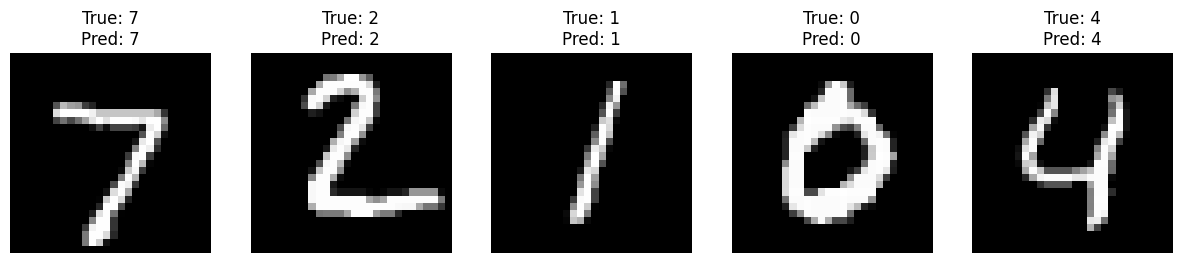

In [58]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, test_loader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images, true_labels = next(iter(test_loader))  # Get a batch of images and labels
    with torch.no_grad():
        outputs = model(images)  # Get model predictions
        _, predicted_labels = torch.max(outputs, 1)  # Get predicted classes

    # Create a figure for visualization
    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))

    for i in range(num_images):
        # Plot each image
        axes[i].imshow(images[i].numpy().squeeze(), cmap='gray')  # Adjust this if the image is not grayscale
        axes[i].set_title(f'True: {true_labels[i].item()}\nPred: {predicted_labels[i].item()}')
        axes[i].axis('off')  # Hide axes

    plt.show()

# Call the function to visualize test results
visualize_predictions(model, test_loader, num_images=5)  # Change num_images as needed
